# INSAT-3D Next-Day Forecasting (PyTorch + GPU)
**Overview**  
- Load INSAT-3D channels (VIS, MIR, SWIR, WV, TIR1) for March 10–31 @00:15  
- Convert DN→physical with **h5py**, downsample to 256×256  
- Build a PyTorch `Dataset` & `DataLoader`  
- Train a simple CNN on **GPU** to predict day N+1 from day N  
- Save & resume checkpoints  
- Visualize training loss and final ORIGINAL vs PREDICTED  


In [5]:
# %% 
# Cell 1: Imports & GPU Setup

# %pip uninstall h5py -y
# %pip install --upgrade h5py==3.8.0
import numpy as np
import os, glob
from datetime import datetime
# Check if a local file named "h5py.py" exists to avoid circular import conflicts.
if os.path.exists("h5py.py"):
	raise ImportError("Local file 'h5py.py' found. Please rename or remove it to avoid conflict with the h5py package.")

import h5py
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Detect GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configuration
DATA_DIR    = r"C:\college\CV\COSMOS\_data"
CHANNELS    = ['VIS','MIR','SWIR','WV','TIR1']
TARGET_SIZE = (256,256)
BATCH_SIZE  = 8
EPOCHS      = 30
CKPT_DIR    = "ckpts_gpu"
os.makedirs(CKPT_DIR, exist_ok=True)


Using device: cpu


## Cell 2: Load & Preprocess One File  
- Read DNs → LUT → physical units via **h5py**  
- Downsample each channel to 256×256 with `interpolate`  


In [6]:
# %%
def load_and_preprocess(fp):
    """Returns torch.FloatTensor shape (C,H,W) on CPU."""
    with h5py.File(fp,'r') as f:
        # read DNs and LUTs
        dn = { ch: f[f"IMG_{ch}"][0].astype(int) for ch in CHANNELS }
        lut = {
            'VIS':  f['IMG_VIS_ALBEDO'][:],
            'MIR':  f['IMG_MIR_RADIANCE'][:],
            'SWIR': f['IMG_SWIR_RADIANCE'][:],
            'WV':   f['IMG_WV_RADIANCE'][:],
            'TIR1': f['IMG_TIR1_TEMP'][:],
        }
    # apply LUT
    bands = [ lut[ch][ dn[ch] ].astype(np.float32) for ch in CHANNELS ]
    arr = np.stack(bands, axis=0)           # (C, H_orig, W_orig)
    t   = torch.from_numpy(arr)             # to tensor

    # downsample spatially
    t = t.unsqueeze(0)                      # (1,C,H,W)
    t = F.interpolate(t, size=TARGET_SIZE, mode='bilinear', align_corners=False)
    return t.squeeze(0)                     # (C,256,256)

# Sanity check
sample_fp = os.path.join(DATA_DIR, "3RIMG_10MAR2025_0015_L1C_SGP_V01R00.h5")
sample = load_and_preprocess(sample_fp)
print("Sample shape:", sample.shape)
for i,ch in enumerate(CHANNELS):
    print(f" {ch}: min={sample[i].min():.3f}, max={sample[i].max():.3f}")


Sample shape: torch.Size([5, 256, 256])
 VIS: min=3.999, max=100.000
 MIR: min=0.000, max=0.346
 SWIR: min=0.000, max=6.700
 WV: min=0.006, max=0.282
 TIR1: min=179.859, max=300.710


## Cell 3: Build the Time-Series Dataset  
- For each day Mar 10→31 pick the 00:15 file  
- Stack into `data` shape `(T,C,H,W)`  
- Create `(X,y)` where `X[n]=day n`, `y[n]=day n+1`  
- Normalize per-channel  


In [7]:
# %%
# assemble daily list
dates = np.arange(np.datetime64('2025-03-10'),
                  np.datetime64('2025-03-31')+1,
                  dtype='datetime64[D]')
data = []
for d in dates:
    tag = datetime.strptime(str(d), '%Y-%m-%d').strftime('%d%b%Y').upper()
    fn  = f"3RIMG_{tag}_0015_L1C_SGP_V01R00.h5"
    fp  = os.path.join(DATA_DIR, fn)
    if not os.path.exists(fp):
        raise FileNotFoundError(fn)
    data.append(load_and_preprocess(fp))

data = torch.stack(data, dim=0)   # (T,C,256,256)
X, y  = data[:-1], data[1:]       # (T-1,C,256,256)

# per-channel normalization
mean = X.mean(dim=(0,2,3), keepdim=True)
std  = X.std(dim=(0,2,3), keepdim=True)
Xn   = (X - mean) / std
yn   = (y - mean) / std

print("Xn.shape, yn.shape:", Xn.shape, yn.shape)
print("Channel means/stds:")
for i,ch in enumerate(CHANNELS):
    print(f"  {ch}: μ={mean[0,i,0,0]:.3f}, σ={std[0,i,0,0]:.3f}")


Xn.shape, yn.shape: torch.Size([21, 5, 256, 256]) torch.Size([21, 5, 256, 256])
Channel means/stds:
  VIS: μ=9.245, σ=7.756
  MIR: μ=0.033, σ=0.020
  SWIR: μ=0.358, σ=0.642
  WV: μ=0.141, σ=0.047
  TIR1: μ=271.153, σ=20.704


## Cell 4: PyTorch Dataset & DataLoader  


In [8]:
# %%
class InsatDataset(Dataset):
    def __init__(self, X, y):
        self.X = X; self.y = y
    def __len__(self):
        return self.X.size(0)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

dataset = InsatDataset(Xn, yn)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Inspect one batch
xb, yb = next(iter(loader))
print("Batch shapes:", xb.shape, yb.shape)


Batch shapes: torch.Size([8, 5, 256, 256]) torch.Size([8, 5, 256, 256])


## Cell 5: Model Definition & Summary  
- Simple CNN encoder–decoder  
- Move model to **GPU**  


In [9]:
# %%
class ForecastCNN(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.enc1 = nn.Conv2d(channels, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)   # 256→128
        self.bottleneck = nn.Conv2d(64,128,3,padding=1)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec1 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec2 = nn.Conv2d(64, 32, 3, padding=1)
        self.out  = nn.Conv2d(32, channels, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.enc1(x))
        x = self.pool(self.relu(self.enc2(x)))
        x = self.relu(self.bottleneck(x))
        x = self.up(x)
        x = self.relu(self.dec1(x))
        x = self.relu(self.dec2(x))
        return self.out(x)

model = ForecastCNN(len(CHANNELS)).to(device)
print(model)
print("Total parameters:", sum(p.numel() for p in model.parameters())/1e6, "M")


ForecastCNN(
  (enc1): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (dec1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (out): Conv2d(32, 5, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
)
Total parameters: 0.186245 M


## Cell 6: Training Loop with GPU & Checkpoints  


In [10]:
# %%
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Resume if checkpoint exists
ckpts = sorted(glob.glob(os.path.join(CKPT_DIR, "epoch_*.pth")))
start_epoch = 1
if ckpts:
    latest = ckpts[-1]
    ckpt   = torch.load(latest, map_location=device)
    model.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt['opt'])
    start_epoch = ckpt['epoch'] + 1
    print(f"Resuming from epoch {start_epoch}")

hist = []
for epoch in range(start_epoch, EPOCHS+1):
    model.train()
    running = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred   = model(xb)
        loss   = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item() * xb.size(0)
    epoch_loss = running / len(dataset)
    hist.append(epoch_loss)
    print(f"Epoch {epoch}/{EPOCHS}  Loss: {epoch_loss:.6f}")
    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model': model.state_dict(),
        'opt':   optimizer.state_dict()
    }, os.path.join(CKPT_DIR, f"epoch_{epoch:02d}.pth"))


Epoch 1/30  Loss: 1.003621
Epoch 2/30  Loss: 0.997947
Epoch 3/30  Loss: 0.989980
Epoch 4/30  Loss: 0.978742
Epoch 5/30  Loss: 0.962537
Epoch 6/30  Loss: 0.939445
Epoch 7/30  Loss: 0.905451
Epoch 8/30  Loss: 0.859203
Epoch 9/30  Loss: 0.800265
Epoch 10/30  Loss: 0.732274
Epoch 11/30  Loss: 0.668558
Epoch 12/30  Loss: 0.615460
Epoch 13/30  Loss: 0.568196
Epoch 14/30  Loss: 0.530537
Epoch 15/30  Loss: 0.505130
Epoch 16/30  Loss: 0.483773
Epoch 17/30  Loss: 0.461202
Epoch 18/30  Loss: 0.445895
Epoch 19/30  Loss: 0.442916
Epoch 20/30  Loss: 0.442898
Epoch 21/30  Loss: 0.440617
Epoch 22/30  Loss: 0.437285
Epoch 23/30  Loss: 0.433723
Epoch 24/30  Loss: 0.430346
Epoch 25/30  Loss: 0.428729
Epoch 26/30  Loss: 0.427158
Epoch 27/30  Loss: 0.425934
Epoch 28/30  Loss: 0.423772
Epoch 29/30  Loss: 0.421167
Epoch 30/30  Loss: 0.419202


## Cell 7: Plot Training Loss  


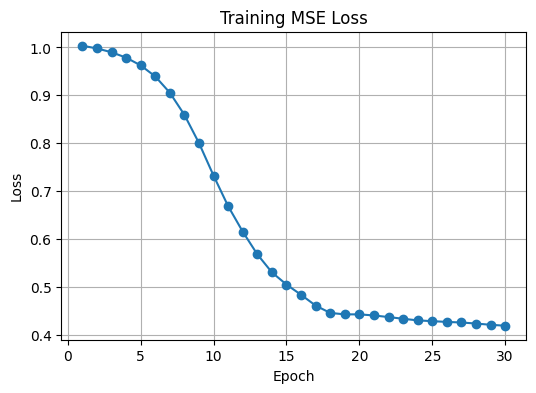

In [11]:
# %%
plt.figure(figsize=(6,4))
plt.plot(range(start_epoch, start_epoch+len(hist)), hist, marker='o')
plt.title("Training MSE Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.grid(True); plt.show()


## Cell 8: Final Prediction & Visualization  


y_true shape: (5, 256, 256)
y_pred shape: (5, 256, 256)


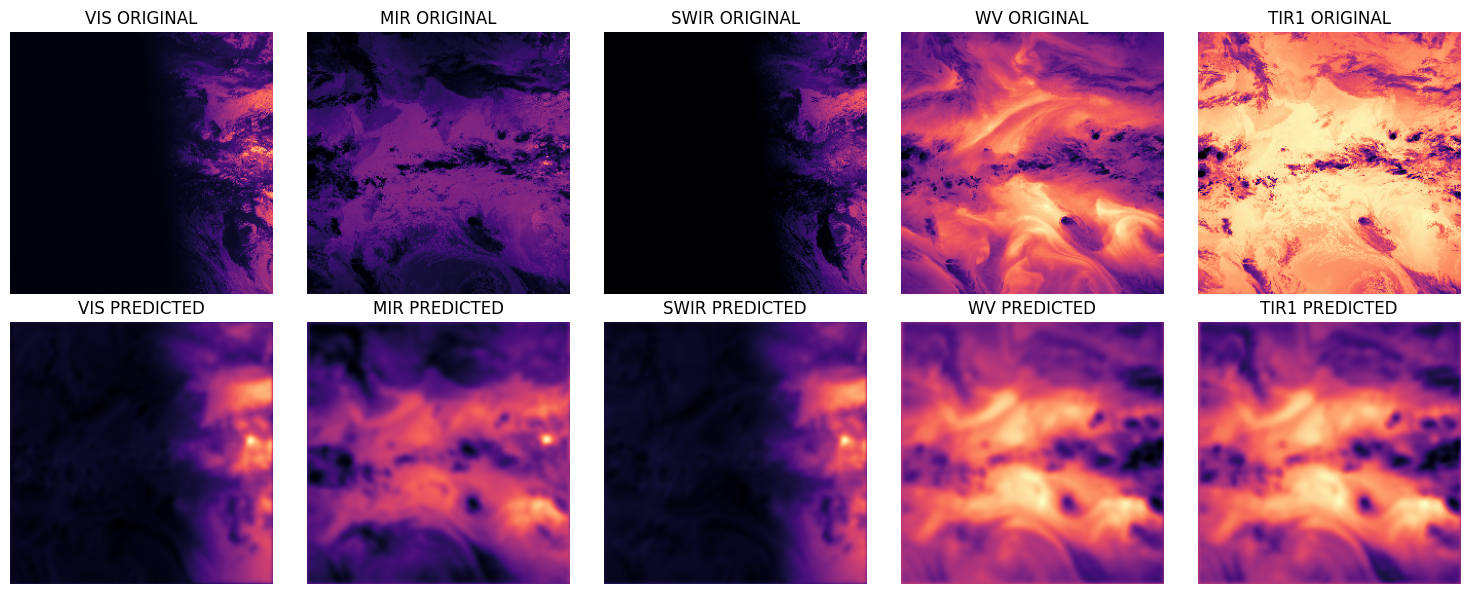

All preds shape: (21, 5, 256, 256)


In [18]:
# %% 
# Cell 8: Final Prediction & Visualization (debugged)

model.eval()

# Predict only the last day (Mar 30→31)
with torch.no_grad():
    x_last = Xn[-1][None].to(device)           # (1, C, H, W)
    y_true = y[-1].cpu().numpy()               # should be (C, H, W)
    y_pred = model(x_last)[0].cpu().numpy()    # (C, H, W)
    # Denormalize
    mean_np = mean.cpu().numpy().reshape(-1,1,1)  # (C,1,1)
    std_np  = std.cpu().numpy().reshape(-1,1,1)
    y_pred = y_pred * std_np + mean_np

# Print shapes to confirm
print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

# If shapes are swapped (H,W,C), uncomment:
# y_true = np.transpose(y_true, (2,0,1))
# y_pred = np.transpose(y_pred, (2,0,1))
# print("After transpose → shapes:", y_true.shape, y_pred.shape)

# Plot ORIGINAL vs PREDICTED
fig, axs = plt.subplots(2, len(CHANNELS), figsize=(len(CHANNELS)*3, 6))
for idx, ch in enumerate(CHANNELS):
    orig = y_true[idx]   # (H, W)
    pred = y_pred[idx]   # (H, W)
    axs[0, idx].imshow(orig, cmap='magma')
    axs[0, idx].set_title(f"{ch} ORIGINAL"); axs[0, idx].axis('off')
    axs[1, idx].imshow(pred, cmap='magma')
    axs[1, idx].set_title(f"{ch} PREDICTED"); axs[1, idx].axis('off')

plt.tight_layout()
plt.show()

# -- Optional: predict for _all_ days --
all_preds = []
model.eval()
with torch.no_grad():
    for sample in Xn:  # each is (C,H,W)
        out = model(sample[None].to(device))[0].cpu().numpy()
        out = out * std_np + mean_np
        all_preds.append(out)
all_preds = np.stack(all_preds, axis=0)  # (T-1, C, H, W)
print("All preds shape:", all_preds.shape)


 ## Cell 9: Save Final Model & Usage
 ```python
 # to save full model
 model.save("final_insat3d_model.h5")

 # to load later:
 from tensorflow.keras.models import load_model
 m = load_model("final_insat3d_model.h5", compile=False)
 ```

 **–– End of Notebook ––**
